<h1>Integral Representation for Multiple Layers </h1>
<h4>An Approximation of Cloaking Via the Periodic Trapezoid Rule</h4>
C. Carvalho, E. Cortes, C. Tsogka (2020)

<h2>Introduction</h2>


Our goal is to simulate optical cloaking devices by calculating how light travels through defined boundaries.  Optical cloaking refers to the act of making something invisible in some directions by preventing the scattering of light as it hits the boundary.  We use boundary integral equation methods to compute the solution in layered boundaries.

In this notebook, we implement in Python an approximation through the use of two main functions: 
<ul>
    <li><u><i>find_boundary_data</i></u> - Implements the Kress Quadrature in order to find the values needed to solve the boundary integral equation system discussed in the next section.</li>
    <li><u><i>make_solution_grid</i></u> - Implements the Periodic Trapezoid Rule (PTR) to approximate the solution inside and outside the boundary in a body-fitted grid.</li>
</ul>

<h3>Problem setting</h3>


We consider 3 concentric layers: $E$, $L$, and $I$ are the domains of the exterior, layer, and interior of the boundary, respectively. $BE$ refers to the domain of the boundary on the exterior, and $BI$ refers to the domain of the boundary on the interior.   
Using the transmission conditions, $u_e = u_l$ on $BE$, $u_l = u_i$ on $BI$, $\frac{1}{k_e} \frac{\partial u_e}{\partial \nu} = \frac{1}{k_l} \frac{\partial u_l}{\partial \nu}$ on $BE$, and $\frac{1}{k_l} \frac{\partial u_l}{\partial \nu} = \frac{1}{k_i} \frac{\partial u_i}{\partial \nu}$ on $BI$, we represent the solutions as

<b><u>Exterior ➜ Layer (in terms of $u_e$)</u></b><br>
$u_e(x) = f(x) + \int_{BE}\frac{\partial \Phi ^{e}}{\partial \nu(y)}(x,y) u_e(y) - \int_{BE}\Phi ^{e}(x,y)\frac{\partial u_e}{\partial \nu} d\sigma _y  = f +  D^e [u_e](x) - S^e[\frac{\partial u_e}{\partial \nu}](x) ,\quad x$ $\epsilon$ $E$

$u_l(x) = -\int_{BE}\frac{\partial \Phi ^{l}}{\partial \nu (y)}(x,y)u_e(y) +\frac{k_l}{k_e}\int_{BE}\Phi ^{l} (x,y) \frac{\partial u_e}{\partial \nu}(y)d\sigma _y =  - D^l [u_e](x) + \frac{k_l}{k_e} S^l[\frac{\partial u_e}{\partial \nu}](x),\quad x$ $\epsilon$ $L$

where we solve for $u_e$, $\frac{\partial u_e}{\partial \nu}$ the system
$$ \begin{bmatrix} \frac{I}{2} - D^{e} & S^{e} \\ \frac{I}{2} + D^{l} & -\frac{k_l}{k_e}S^{l} \end{bmatrix} \begin{bmatrix}u_e \\ \frac{\partial u_e}{\partial \nu}\end{bmatrix} = \begin{bmatrix} f \\ 0 \end{bmatrix}, \quad x \in BE$$

<b><u>Interior (in terms of $u_l$) </u></b><br>
$u_i(x) = -\int_{BI}\frac{\partial \Phi ^{i}}{\partial \nu (y)}(x,y)u_l(y) + \frac{k_i}{k_l}\int_{BI}\Phi ^{i} (x,y) \frac{\partial u_l}{\partial \nu}(y)d\sigma _y =  - D^i [u_l](x) + \frac{k_i}{k_l} S^i[\frac{\partial u_l}{\partial \nu}](x) ,\quad x$ $\epsilon$ $I$

Note that the representation of $u_l$, $u_i$ gives us:
$$u_l(x_{BI}) = - D^l [u_e](x_{BI}) + \frac{k_l}{k_e} S^l[\frac{\partial u_e}{\partial \nu}](x_{BI}), x_{BI} \in BI$$
$$\frac{1}{2}u_i(x_{BI}) = - D^i [u_l](x_{BI}) + \frac{k_i}{k_l} S^i[\frac{\partial u_l}{\partial \nu}](x_{BI}), x_{BI} \in BI$$


Then we can find $\frac{\partial u_l}{\partial \nu}(x_{BI})$ using the transmission condition $u_l = u_i$ on $BI$:

$$\frac{\partial u_l}{\partial \nu}(x_{BI}) = \left(\frac{k_l}{k_i}(S^i)^{-1}\right)\left(\frac{I}{2} + D^i\right)u_l(y), \quad x_{BI} \in BI$$

We can then directly solve for $u_i(x)$ from these results.

<h2>Implementation</h2>

In [2]:
%matplotlib inline
import sympy as sp
import numpy as np
from sympy import cos, sin, exp
from numpy import sqrt, log
from scipy.special import hankel1
from scipy.special import jv as besselj
from scipy.linalg import toeplitz
from matplotlib import pyplot as plt
from numpy import vectorize
from mpl_toolkits.mplot3d import Axes3D


<h3>Boundary class definition</h3>

In [3]:
from Boundary import *

<h3>Calculation of $u$ and $\frac{\partial u}{\partial \nu}$ on the boundary (using Kress quadrature)</h3>

In [4]:
def find_boundary_data(f, xbdy, ybdy, ν, J, κ, M, k_e, k_l):
    '''
    Computes u and du/dv on the boundary BE by solving the BIE system
    
    Parameters
    ==========
    f : data
    xbdy : x-coordinate on the boundary
    ybdy : y-coordinate on the boundary
    ν : normal 
    J : Jacobian
    κ : curvature
    M : quadrature points
    k_e : wavenumber exterior
    k_l : waevenumber layer
    
    Returns
    =======
    u_e : solution on the boundary, u
    dvu_e : normal derivative on the boundary
    '''
    
    E_C =  np.euler_gamma # Euler's constant
    N = M / 2
    m = np.arange(1, N)
    k_ratio = k_l/k_e

    # Create array for ifft...
    a = [0]
    a.extend(1/m)
    a.append(1/N)
    a.extend((1/m)[::-1])

    Rj = -2 * np.pi * np.fft.ifft(a)
    R = np.real(toeplitz(Rj, Rj))

    # Prepare arrays for solving integral equation of the boundary (Kress pt. 2)
    A = np.zeros((2*M, 2*M), dtype=complex)
    F = np.zeros(2*M, dtype=complex)

    cosθ_mn = np.zeros((M,M))
    #distance_mn = np.zeros((M, M))
    logterm_mn = np.zeros((M, M))
    
    besselj_0e_mn = np.zeros((M, M), dtype=complex)
    besselj_1e_mn = np.zeros((M, M), dtype=complex)
    hankel1_0e_mn = np.zeros((M, M), dtype=complex)
    hankel1_1e_mn = np.zeros((M, M), dtype=complex)
    
    besselj_0l_mn = np.zeros((M, M), dtype=complex)
    besselj_1l_mn = np.zeros((M, M), dtype=complex)
    hankel1_0l_mn = np.zeros((M, M), dtype=complex)
    hankel1_1l_mn = np.zeros((M, M), dtype=complex)
    
    logterm_o = {}
    for i in range(-M,M):
        if i != 0: 
            logterm_o[i] = log(float(4 * np.power(np.sin(0.5 * i * dt), 2)))
        
    
    for m in range(0, M):
        for n in range(0, M):
            rdiff = np.asarray([xbdy[m] - xbdy[n], ybdy[m] - ybdy[n]]);
            distance = sqrt(np.power(rdiff[:][0], 2) + np.power(rdiff[:][1], 2))
            #distance_mn[m,n] = distance
            besselj_0e_mn[m,n] = besselj(0, k_e * distance) * J[m]
            besselj_0l_mn[m,n] = besselj(0, k_l * distance) * J[m]
            if m != n:
                cosθ_mn[m, n] = ν[0][n]*(rdiff[0]/distance) + ν[1][n]*(rdiff[1]/distance)
                logterm_mn[m,n] = logterm_o[m-n]

                besselj_1e_mn[m,n] = besselj(1, k_e * distance) * J[n]
                hankel1_1e_mn[m,n] = hankel1(1, k_e * distance) * J[n]
                hankel1_0e_mn[m,n] = hankel1(0, k_e * distance) * J[n]

                besselj_1l_mn[m,n] = besselj(1, k_l * distance) * J[n]
                hankel1_1l_mn[m,n] = hankel1(1, k_l * distance) * J[n]
                hankel1_0l_mn[m,n] = hankel1(0, k_l * distance) * J[n]
            
    #Compute kernels of exterior of boundary
    L1_e = 0.5 * k_e / np.pi * cosθ_mn * besselj_1e_mn
    L2_e = 0.5 * 1j * k_e * cosθ_mn * hankel1_1e_mn - L1_e * logterm_mn
    M1_e = -0.5 / np.pi *  besselj_0e_mn
    M2_e = 0.5 * 1j * hankel1_0e_mn - M1_e * logterm_mn
     
    diag = np.arange(0,M)
    M2_e[diag, diag] = J[diag] * ( 0.5 * 1j - E_C / np.pi - 0.5 / np.pi * np.log( 0.25 * np.power(k_e, 2) * np.power(J[diag], 2)))
    L1_e[diag, diag] = 0
    L2_e[diag, diag] = 0.5 / np.pi * κ[diag] * J[diag]
            
    L_e = 0.5 * R * L1_e + 0.5 * (np.pi / N) * L2_e
    M_e = 0.5 * R * M1_e + 0.5 * (np.pi / N) * M2_e
                
    #Calculate kernels of interior of boundary
    L1_l = 0.5 * k_l / np.pi * cosθ_mn * besselj_1l_mn
    L2_l = 0.5 * 1j * k_l * cosθ_mn * hankel1_1l_mn - L1_l * logterm_mn
    M1_l = -0.5 / np.pi *  besselj_0l_mn
    M2_l = 0.5 * 1j * hankel1_0l_mn - M1_l * logterm_mn
    
    #Replace diagonals where m=n with exception cases
    L1_l[diag, diag] = 0
    L2_l[diag, diag] = 0.5 / np.pi * κ[diag] * J[diag];
    M2_l[diag, diag] = J[diag] * ( 0.5j - E_C / np.pi - 0.5 / np.pi * np.log( 0.25 * np.power(k_l, 2) * np.power(J[diag], 2)))
    
    L_l =0.5 * R * L1_l + 0.5 * (np.pi / N) * L2_l
    M_l = 0.5 * R * M1_l + 0.5 *(np.pi / N) * M2_l

    #Matrix of combined representation formulas       
    A11 = 0.5 * np.identity(M) - L_e
    A12 = M_e
    A21 = 0.5 * np.identity(M) + L_l
    A22 = -k_ratio * M_l

    #Combine A's into one matrix, A
    A[0:M, 0:M] = A11; A[0:M, M: 2*M] = A12
    A[M: 2*M, 0:M] = A21; A[M: 2*M, M: 2*M] = A22
    
    #Make matrix for f and 0's, call it F
    F[0:M] = f[0:M]
    
    #Solve for u and dvu from AU = F
    U = np.linalg.solve(A,F)
    u_e = U[0:M]
    dvu_e = U[M: 2*M]
    return u_e, dvu_e

In [5]:
def find_dvuL(xbdy, ybdy, ν, J, κ, M, k_l, k_i, uL_BI):
    '''
    Computes du/dv on the boundary BI by solving the BIE system
    
    Parameters
    ==========
    xbdy : x-coordinate on the boundary 
    ybdy : y-coordinate on the boundary 
    ν : normal 
    J : Jacobian
    κ : curvature
    M : quadrature points
    k_l : waevenumber layer
    k_i : wavenumber interior
    uL_BI : trace of u_l on BI 
    
    Returns
    =======
    dvu_l : normal derivative on the boundary
    '''
    
    E_C =  np.euler_gamma # Euler's constant
    N = M / 2
    m = np.arange(1, N)
    k_ratio = k_i/k_l

    # Create array for ifft...
    a = [0]
    a.extend(1/m)
    a.append(1/N)
    a.extend((1/m)[::-1])

    Rj = -2 * np.pi * np.fft.ifft(a)
    R = np.real(toeplitz(Rj, Rj))

    cosθ_mn = np.zeros((M,M))
    #distance_mn = np.zeros((M, M))
    logterm_mn = np.zeros((M, M))
    
    besselj_0i_mn = np.zeros((M, M), dtype=complex)
    besselj_1i_mn = np.zeros((M, M), dtype=complex)
    hankel1_0i_mn = np.zeros((M, M), dtype=complex)
    hankel1_1i_mn = np.zeros((M, M), dtype=complex)
    
    
    logterm_o = {}
    for i in range(-M,M):
        if i != 0: 
            logterm_o[i] = log(float(4 * np.power(np.sin(0.5 * i * dt), 2)))
        
    
    for m in range(0, M):
        for n in range(0, M):
            rdiff = [xbdy[m] - xbdy[n], ybdy[m] - ybdy[n]];
            distance = sqrt(np.power(rdiff[0], 2) + np.power(rdiff[1], 2))
            #distance_mn[m,n] = distance
            besselj_0i_mn[m,n] = besselj(0, k_i * distance) * J[m]
            if m != n:
                cosθ_mn[m, n] = ν[0][n]*(rdiff[0]/distance) + ν[1][n]*(rdiff[1]/distance)
                logterm_mn[m,n] = logterm_o[m-n]

                besselj_1i_mn[m,n] = besselj(1, k_i * distance) * J[n]
                hankel1_1i_mn[m,n] = hankel1(1, k_i * distance) * J[n]
                hankel1_0i_mn[m,n] = hankel1(0, k_i * distance) * J[n]
            
    #Calculate kernels of interior of boundary
    L1_i = 0.5 * k_i / np.pi * cosθ_mn * besselj_1i_mn
    L2_i = 0.5 * 1j * k_i * cosθ_mn * hankel1_1i_mn - L1_i * logterm_mn
    M1_i = -0.5 / np.pi * besselj_0i_mn
    M2_i = 0.5 * 1j * hankel1_0i_mn - M1_i * logterm_mn
    
    #Replace diagonals where m=n with exception cases
    diag = np.arange(0,M)
    L1_i[diag, diag] = 0
    L2_i[diag, diag] = 0.5 / np.pi * κ[diag] * J[diag];
    M2_i[diag, diag] = J[diag] * ( 0.5j - E_C / np.pi - 0.5 / np.pi * np.log( 0.25 * np.power(k_l, 2) * np.power(J[diag], 2)))
    
    L_i =0.5 * R * L1_i + 0.5 * (np.pi / N) * L2_i
    M_i = 0.5 * R * M1_i + 0.5 *(np.pi / N) * M2_i

    #Matrix of combined representation formulas       
    A = 0.5 * np.identity(M) + L_i
    B = (1/k_ratio) * M_i
    Binv = np.linalg.inv(B)
    C = np.matmul(Binv, A)
    dvu_l = np.matmul(C, uL_BI[0:M])
    
    return dvu_l

<h3>Calculation of solution grid (using Periodic Trapezoid Rule)</h3>

In [41]:
def make_grid_between(ngrid, xbdy1, ybdy1, xbdy2, ybdy2, M):
    '''
    Computes the grid points along normal from boundary layer
    
    Parameters
    ==========
    ngrid : number of pts along normal
    xbdy : x pts of boundary
    ybdy : y pts of boundary
    ν : normal vector of boundary
    M : number of pts on boundary
    D : depth of  layer
    direction : +1 for outward normal, -1 for inward normal
    
    Returns
    =======
    x : x pts in layer
    y : y pts in layer
    
    '''
    x  = np.zeros((M + 1, ngrid ))
    y  = np.zeros((M + 1, ngrid ))
    for m in range(0, M):
        x_diff = xbdy2[m] - xbdy1[m]
        y_diff = ybdy2[m] - ybdy1[m]
        dist = sqrt(x_diff**2 + y_diff**2)
    
        dn = dist/ngrid
        rgrid = np.linspace(0+dn, dist, num=ngrid,endpoint=True, retstep=False, dtype=None, axis=0)
        
        x[m, :] = xbdy1[m] + rgrid*(x_diff / dist)
        y[m, :] = ybdy1[m] + rgrid*(y_diff / dist)
    
    #Impose Periodicity 
    x[M][:] = x[0][:]
    y[M][:] = y[0][:]
    
    return x, y

In [7]:
def make_grid(ngrid, xbdy, ybdy, ν, M, D, direction):
    '''
    Computes the grid points along normal from boundary layer
    
    Parameters
    ==========
    ngrid : number of pts along normal
    xbdy : x pts of boundary
    ybdy : y pts of boundary
    ν : normal vector of boundary
    M : number of pts on boundary
    D : depth of  layer
    direction : +1 for outward normal, -1 for inward normal
    
    Returns
    =======
    x : x pts in layer
    y : y pts in layer
    
    '''
    
    dn = D/ngrid
    rgrid = np.linspace(0+dn, D, num=ngrid,endpoint=True, retstep=False, dtype=None, axis=0)
    x  = np.zeros((M + 1, ngrid ))
    y  = np.zeros((M + 1, ngrid ))
    for m in range(0, M):
        x[m, :] = xbdy[m] + direction*rgrid*ν[0][m]
        y[m, :] = ybdy[m] + direction*rgrid*ν[1][m]
    
    #Impose Periodicity 
    x[M][:] = x[0][:]
    y[M][:] = y[0][:]
    
    return x, y

In [8]:
def make_solution_layers(ν, D, J, κ, k_l, k_i, M, ngrid, v_l, x_l, y_l):
    '''
    Computes the representation in interior layer
    
    Parameters
    ==========
    ν : normal on BE
    D : depth of the layers
    J : Jacobian on BE
    κ : curvature on BE
    k_e : wavenumber exterior
    k_l : wavenumber layer
    k_i : wavenumber interior
    M : quadrature points along the boundaries
    ngrid : quadrature points along the normal 
    v_l : solution of preceding layer
    x_l : x-coordinate of preceding layer
    y_l : y-coordinate of preceding layer
    
    Returns
    =======
    v_i : solution the layer I
    
    '''
    kernelD_i_mn = np.zeros((M + 1, ngrid), dtype=complex)
    kernelS_i_mn = np.zeros((M + 1, ngrid), dtype=complex)
    
    k_ratio3 = k_i/k_l
    
    xbdyI = x_l[:,ngrid - 1]
    ybdyI = y_l[:,ngrid - 1]
    uL = v_l[:,ngrid - 1]
    
    #uL =  np.exp(1j * k_l * (np.cos(alpha) * xbdyI + np.sin(alpha) * ybdyI))
    
    dvuL = find_dvuL(xbdyI, ybdyI, ν, J, κ, M, k_l, k_i, uL)
    
    #df = [1j * k_l * np.cos(alpha) * np.exp(1j * k_l * (np.cos(alpha) * xbdyI + np.sin(alpha) * ybdyI)), 1j * k_l * np.sin(alpha) * np.exp(1j * k_l * (np.cos(alpha) * xbdyI + np.sin(alpha) * ybdyI))]
    #dvuL = ν[0][:] * df[0][0:M] + ν[1][:] * df[1][0:M]
    
    
    x_i, y_i = make_grid(ngrid, xbdyI, ybdyI, ν, M, D, -1)
    
    for m in range(0, M):
        for n in range(0, ngrid):#change here
        # INTERIOR:
            xi_diff = x_i[m][n] - xbdyI[0:M]
            yi_diff = y_i[m][n] - ybdyI[0:M]
            
            distance_i = sqrt(xi_diff**2 + yi_diff**2) #(r in kress)
            cosθ_i = (ν[0][:]*xi_diff + ν[1][:]*yi_diff) / distance_i
            
            kernelD_i = 0.25 * 1j * (k_i * cosθ_i * hankel1(1, k_i*distance_i))
            kernelS_i = 0.25 * 1j * hankel1(0, k_i*distance_i)
           
            kernelD_i_mn[m,n] = sum(kernelD_i * J[m] * uL[0:M])
            kernelS_i_mn[m,n] = sum(kernelS_i * J[m] * dvuL[0:M])
            
    v_i = -kernelD_i_mn * dt + k_ratio3 * kernelS_i_mn * dt
    
    # Impose periodicity
    v_i[M][:] = v_i[0][:]
    
    return v_i, x_i, y_i

In [9]:
def make_solution_grid(uE, dvuE, xbdy, ybdy, ν, D, J, κ, k_e, k_l, k_i, M, ngrid, layers):
    '''
    Computes the representation of the solution in the three layers
    
    Parameters
    ==========
    uE : boundary data on BE
    dvuE : normal trace data on BE
    xbdy : x-coordinate on the boundary on BE
    ybdy : y-coordinate on the boundary on BE
    ν : normal on BE
    D : depth of the layers
    J : Jacobian on BE
    κ : curvature on BE
    k_e : wavenumber exterior
    k_l : wavenumber layer
    k_i : wavenumber interior
    M : quadrature points along the boundaries
    ngrid : quadrature points along the normal 
    
    Returns
    =======
    v_e : solution the layer E
    v_l : solution the layer L
    v_i : solution the layer I
    
    '''
    
    x_e, y_e = make_grid(ngrid, xbdy, ybdy, ν, M, D[0], 1);
    x_l, y_l = make_grid(ngrid, xbdy, ybdy, ν, M, D[1], -1);
    
    k_ratio1 = k_l/k_e
    k_ratio2 = (k_l**2)/(k_i*k_e)

    # Allocate memory for the solution
    kernelD_e_mn = np.zeros((M + 1, ngrid), dtype=complex)
    kernelS_e_mn = np.zeros((M + 1, ngrid), dtype=complex)
    kernelD_l_mn = np.zeros((M + 1, ngrid), dtype=complex)
    kernelS_l_mn = np.zeros((M + 1, ngrid), dtype=complex)

    f = np.exp(1j * k_e * (np.cos(alpha) * x_e + np.sin(alpha) * y_e))

    for m in range(0, M):
        for n in range(0, ngrid): 
            #EXTERIOR:
            xe_diff = x_e[m][n] - xbdy 
            ye_diff = y_e[m][n] - ybdy 
        
            distance_e = sqrt(xe_diff**2 + ye_diff**2) #(r in kress)
            cosθ_e = (ν[0][:]*xe_diff + ν[1][:]*ye_diff ) / distance_e;
    
            
            kernelD_e = 0.25 * 1j * k_e * cosθ_e * hankel1(1, k_e*distance_e)
            kernelS_e = 0.25 * 1j * hankel1(0, k_e*distance_e) # kress (2.2+)
            
            kernelD_e_mn[m,n] = sum(kernelD_e * J[m] * uE)
            kernelS_e_mn[m,n] = sum(kernelS_e * J[m] * dvuE)
            
            # LAYER:
            xl_diff = x_l[m][n] - xbdy
            yl_diff = y_l[m][n] - ybdy
            
            distance_l = sqrt(xl_diff**2 + yl_diff**2) #(r in kress)
            cosθ_l = (ν[0][:]*xl_diff + ν[1][:]*yl_diff) / distance_l
            
            kernelD_l = 0.25 * 1j * (k_l * cosθ_l * hankel1(1, k_l*distance_l))
            kernelS_l = 0.25 * 1j * hankel1(0, k_l*distance_l)
           
            kernelD_l_mn[m,n] = sum(kernelD_l * J[m] * uE)
            kernelS_l_mn[m,n] = sum(kernelS_l * J[m] * dvuE)
                        
    
    v_e = f + kernelD_e_mn * dt - kernelS_e_mn * dt
    v_l = -kernelD_l_mn * dt + k_ratio1 * kernelS_l_mn * dt
    v_e[M][:] = v_e[0][:]
    v_l[M][:] = v_l[0][:]
    
    # Set parameters for first interior layer
    v_i0 = v_l
    x_i0 = x_l
    y_i0 = y_l
    
    # Store solutions
    x_i = []
    y_i = []
    v_i = []
    for i in range(0, layers):
        v_temp, x_temp, y_temp = make_solution_layers(ν, D[2 + i], J, κ, k_l, k_i, M, ngrid, v_i0, x_i0, y_i0)
        v_i.append(v_temp)
        x_i.append(x_temp)
        y_i.append(y_temp)
        v_i0 = v_temp
        x_i0 = x_temp
        y_i0 = y_temp
    
    return v_e, v_l, x_e, y_e, x_l, y_l, v_i, x_i, y_i

In [10]:
def find_exact_planewave(x, y, k, alpha):
    exact = np.exp(1j * k * (np.cos(alpha) * x + np.sin(alpha) * y))
    return exact

<h2>Numerical results</h2>

In order to validate our method, we will firstly display the results for a case such that the solution is known.  This solution is such that:
$$f(x) = e^{i k_e (cos(\alpha)x + sin(\alpha)y)}$$
$$k_e = k_i$$<br>
The values of $\alpha$, $k_e$, and $k_i$ are chosen below when we set the paramaters for our calculations.  Our solution is given by the value $v$ and is compared to the known solution, which we call $exact$.  This error is displayed on a log plot which follows the surface plots of the approximate and exact solutions.<br><br>

Our method is then use to examine our results for different scenarios.  For example, we apply our method for the case when $k_i = -0.5 k_e$.  We also test our method for different shapes of the boundary, such as a star-shaped boundary.

<h3>Defined Boundary Curves</h3>

In [31]:
# Specify the shape of the boundaries
t = sp.Symbol('t')

Circle = (3*cos(t), 3*sin(t))
Ellipse = (2*cos(t), 1.5*sin(t))
Star = ((0.5+0.3*cos(3*t))*cos(t), (0.5+0.3*cos(3*t))*sin(t))
C = Boundary(Circle)
E = Boundary(Ellipse)
S = Boundary(Star)
lclassB(E)
lclassB(C)
lclassB(S)

<h3>Initial condition and parameters</h3>

In [12]:
# Evaluate boundary data
def def_f_as_planewave(bdy, k, alpha):
    xbdy = bdy[0][:]
    ybdy = bdy[1][:]
    
    # Plane Wave Equation
    f = np.exp(1j * k * (np.cos(alpha) * xbdy + np.sin(alpha) * ybdy))
    return xbdy, ybdy, f

<h2>Display of the results</h2>

<h3>Ellipse boundary where $k_e = k_i = 3$</h3>
We use this as a validation of our method since the solution is known for $k_e = k_i$.  When they are equal, this is the same as saying the interior and the exterior are the same medium, so there no change in the source $f$ across the boundary.

<h4>Validation of the boundary data</h4>

In [56]:
# Evaluation of the results for given parameters
# USER INPUTS: Modify M, k_e, k_i, and ngrid to modify results
M = 100
k_e = 3
k_l = 3
k_i = 3 # Currently same for all interior layers
alpha = np.pi / 5
ngrid = 49

# Values for parameterization of the boundary
dt = 2.0 * np.pi/(M)
θ = np.arange(0, 2* np.pi , dt)
D = [1, 1, .5, .5]; # Thickness of each layer
layers = 2

In [57]:
# Using bdy, ν, J, and κ function names for ellipse
xbdy, ybdy, f  = def_f_as_planewave(C.y_l(θ), k_e, alpha)
xbdy2, ybdy2, f = def_f_as_planewave(E.y_l(θ), k_l, alpha)
xbdy3, ybdy3, f = def_f_as_planewave(S.y_l(θ), k_i, alpha)
uE, dvuE = find_boundary_data(f, xbdy, ybdy, C.ν_l(θ), C.J_l(θ), C.κ_l(θ), M, k_e, k_l)

In [58]:
x,y = make_grid_between(ngrid, xbdy, ybdy, xbdy2, ybdy2, M)
x2, y2 = make_grid_between(ngrid, xbdy2, ybdy2, xbdy3, ybdy3, M)

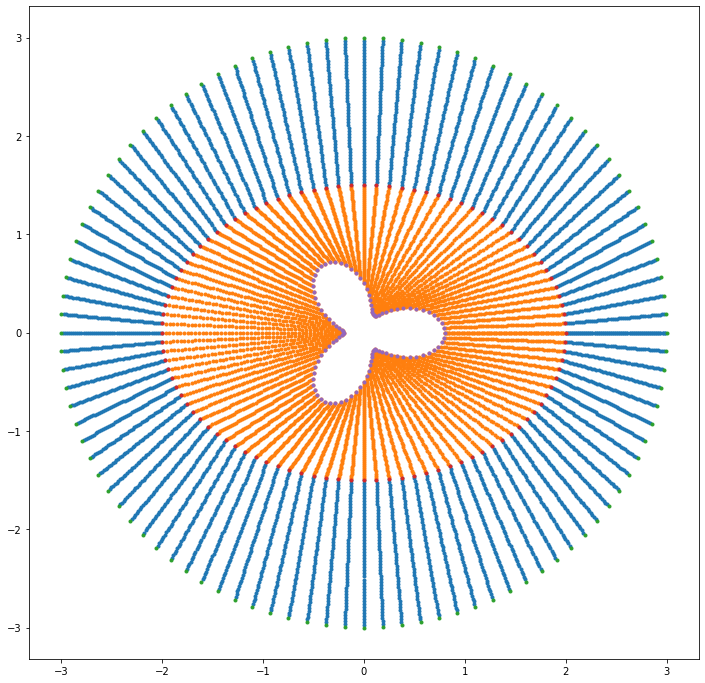

In [59]:
fig, ax = plt.subplots(1, 1,figsize=(12,12))
ax.scatter(x, y, marker=".")
ax.scatter(x2, y2, marker=".")
ax.scatter(xbdy, ybdy, marker=".")
ax.scatter(xbdy2 ,ybdy2, marker=".")
ax.scatter(xbdy3, ybdy3, marker=".")

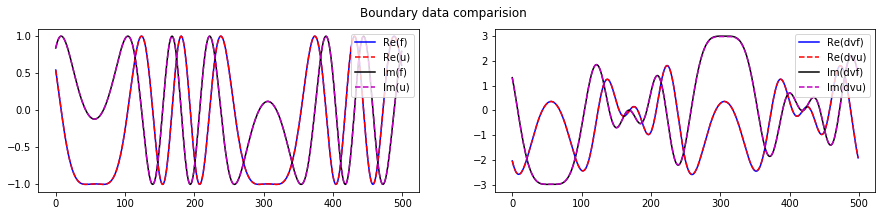

In [13]:
# Calculate exact
df = [1j * k_e * np.cos(alpha) * np.exp(1j * k_e * (np.cos(alpha) * xbdy + np.sin(alpha) * ybdy)), 1j * k_e * np.sin(alpha) * np.exp(1j * k_e * (np.cos(alpha) * xbdy + np.sin(alpha) * ybdy))]
dvf = C.ν_l(θ)[0] * df[0] + C.ν_l(θ)[1] * df[1]

fig = plt.figure(figsize=(15,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.suptitle('Boundary data comparision');
ax1.plot(np.real(uE), 'b', label='Re(f)')
ax1.plot(np.real(f), 'r--', label='Re(u)')
ax1.plot(np.imag(uE), 'k', label='Im(f)')
ax1.plot(np.imag(f), 'm--', label='Im(u)')
ax1.legend(loc='upper right');
ax2.plot(np.real(dvuE), 'b', label='Re(dvf)')
ax2.plot(np.real(dvf), 'r--', label='Re(dvu)')
ax2.plot(np.imag(dvuE), 'k', label='Im(dvf)')
ax2.plot(np.imag(dvf), 'm--', label='Im(dvu)')
ax2.legend(loc='upper right');

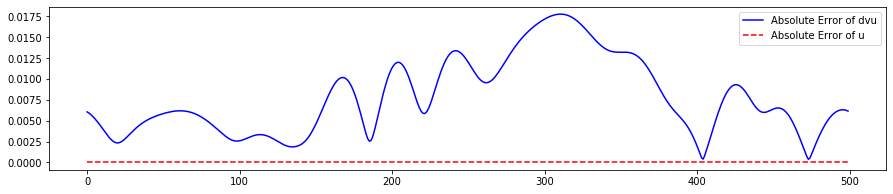

In [14]:
fig2 = plt.figure(figsize=(15,3))
ax1 = fig2.add_subplot(111)
ax1.plot(np.abs(dvuE - dvf), 'b', label='Absolute Error of dvu')
ax1.plot(np.abs(uE - f), 'r--', label='Absolute Error of u')
ax1.legend(loc='upper right');

As seen above, our calculation of $u_i$ (called u) and $\frac{\partial u_i}{\partial \nu}$ (called dvu) is accurate compared to the actual values of $f$ and $\frac{\partial f}{\partial \nu}$.  Therefore, we expect our final results to be accurate as well, so long as our method in _make-solution-grid_ is correct.

<h4>Compute the solution </h4>

In [15]:
v_e, v_l, x_e, y_e, x_l, y_l, v_i, x_i, y_i = make_solution_grid(uE, dvuE, xbdy, ybdy, C.ν_l(θ), D, 
                                                                C.J_l(θ), C.κ_l(θ), k_e, k_l, k_i, M, ngrid, layers)
# Find exact solution for known k_i = k_j for all i, j
exact_e = find_exact_planewave(x_e, y_e, k_e, alpha)
exact_l = find_exact_planewave(x_l, y_l, k_l, alpha)
exact_i = []
for i in range(0, layers):
    exact_temp = find_exact_planewave(x_i[i], y_i[i], k_i, alpha)
    exact_i.append(exact_temp)

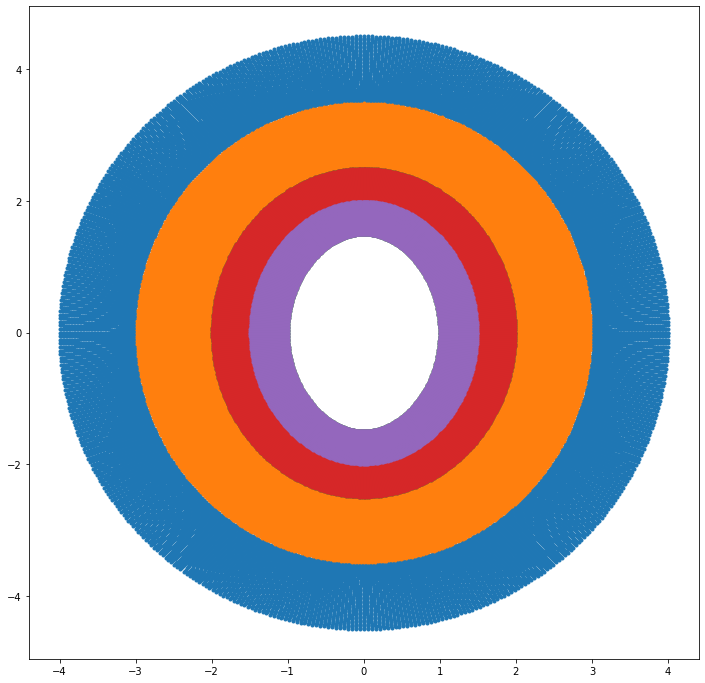

In [16]:
fig, ax = plt.subplots(1, 1,figsize=(12,12))
ax.scatter(x_e, y_e, marker=".")
ax.scatter(x_l ,y_l, marker=".")
ax.scatter(x_i, y_i, marker=".")
for i in range(0, layers):
    ax.scatter(x_i[i],y_i[i],marker=".")

(-4.0, 4.0, -4.5, 4.5)

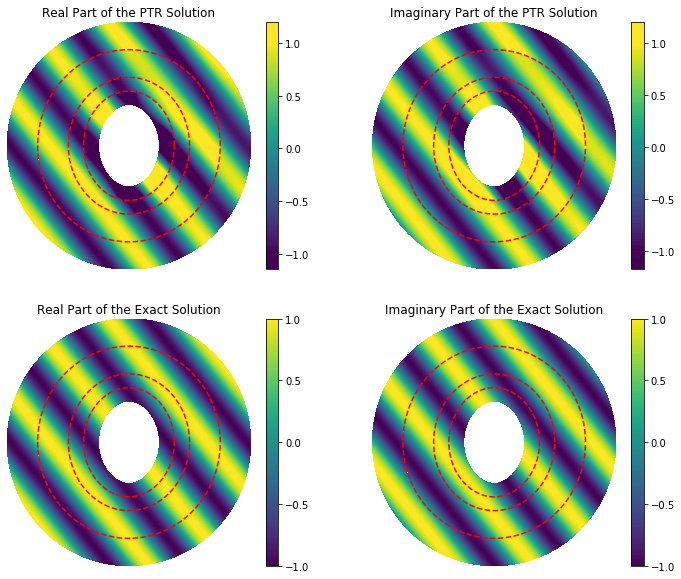

In [17]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(2 ,2 ,1)
real1 = plt.contourf(x_l, y_l, np.real(v_l), 100, cmap=plt.get_cmap('viridis'), vmin=-1, vmax=1)
real2 = plt.contourf(x_e, y_e, np.real(v_e), 100, cmap=plt.get_cmap('viridis'), vmin=-1, vmax=1)
ax.plot(xbdy, ybdy, 'r--', zorder = (layers*5))
for i in range(0, layers):
    real3=plt.contourf(x_i[i], y_i[i], np.real(v_i[i]), 100, cmap=plt.get_cmap('viridis'), vmin=-1, vmax=1)
    ax.plot(x_i[i][:,0], y_i[i][:,0], 'r--', zorder = (layers*5))
    
plt.title("Real Part of the PTR Solution")
fig.colorbar(real1, ticks = [-1, -0.5, 0, 0.5, 1])
plt.axis('off')


ax = fig.add_subplot(2, 2, 2)
imag1 = plt.contourf(x_l, y_l, np.imag(v_l), 100, cmap=plt.get_cmap('viridis'), vmin=-1, vmax=1)
imag2 = plt.contourf(x_e, y_e, np.imag(v_e), 100, cmap=plt.get_cmap('viridis'), vmin=-1, vmax=1)
ax.plot(xbdy, ybdy, 'r--', zorder = (layers*5))
for i in range(0, layers):
    imag3=plt.contourf(x_i[i], y_i[i], np.imag(v_i[i]), 100, cmap=plt.get_cmap('viridis'), vmin=-1, vmax=1)
    ax.plot(x_i[i][:,0], y_i[i][:,0], 'r--', zorder = (layers*5))
    
plt.title("Imaginary Part of the PTR Solution")
fig.colorbar(imag1, ticks = [-1, -0.5, 0, 0.5, 1])
plt.axis('off')



ax = fig.add_subplot(2 ,2 ,3)
real1 = plt.contourf(x_l, y_l, np.real(exact_l), 100, cmap=plt.get_cmap('viridis'), vmin=-1, vmax=1)
real2 = plt.contourf(x_e, y_e, np.real(exact_e), 100, cmap=plt.get_cmap('viridis'), vmin=-1, vmax=1)
ax.plot(xbdy, ybdy, 'r--', zorder = (layers*5))
for i in range(0, layers):
    real3=plt.contourf(x_i[i], y_i[i], np.real(exact_i[i]), 100, cmap=plt.get_cmap('viridis'), vmin=-1, vmax=1)
    ax.plot(x_i[i][:,0], y_i[i][:,0], 'r--', zorder = (layers*5))

plt.title("Real Part of the Exact Solution")
fig.colorbar(real1, ticks = [-1, -0.5, 0, 0.5, 1])
plt.axis('off')


ax = fig.add_subplot(2 ,2 ,4)
imag1 = plt.contourf(x_l, y_l, np.imag(exact_l), 100, cmap=plt.get_cmap('viridis'), vmin=-1, vmax=1)
imag2 = plt.contourf(x_e, y_e, np.imag(exact_e), 100, cmap=plt.get_cmap('viridis'), vmin=-1, vmax=1)
ax.plot(xbdy, ybdy, 'r--', zorder = (layers*5))
for i in range(0, layers):
    imag3=plt.contourf(x_i[i], y_i[i], np.imag(exact_i[i]), 100, cmap=plt.get_cmap('viridis'), vmin=-1, vmax=1)
    ax.plot(x_i[i][:,0], y_i[i][:,0], 'r--', zorder = (layers*5))

plt.title("Imaginary Part of the Exact Solution")
fig.colorbar(imag1, ticks = [-1, -0.5, 0, 0.5, 1])
plt.axis('off')

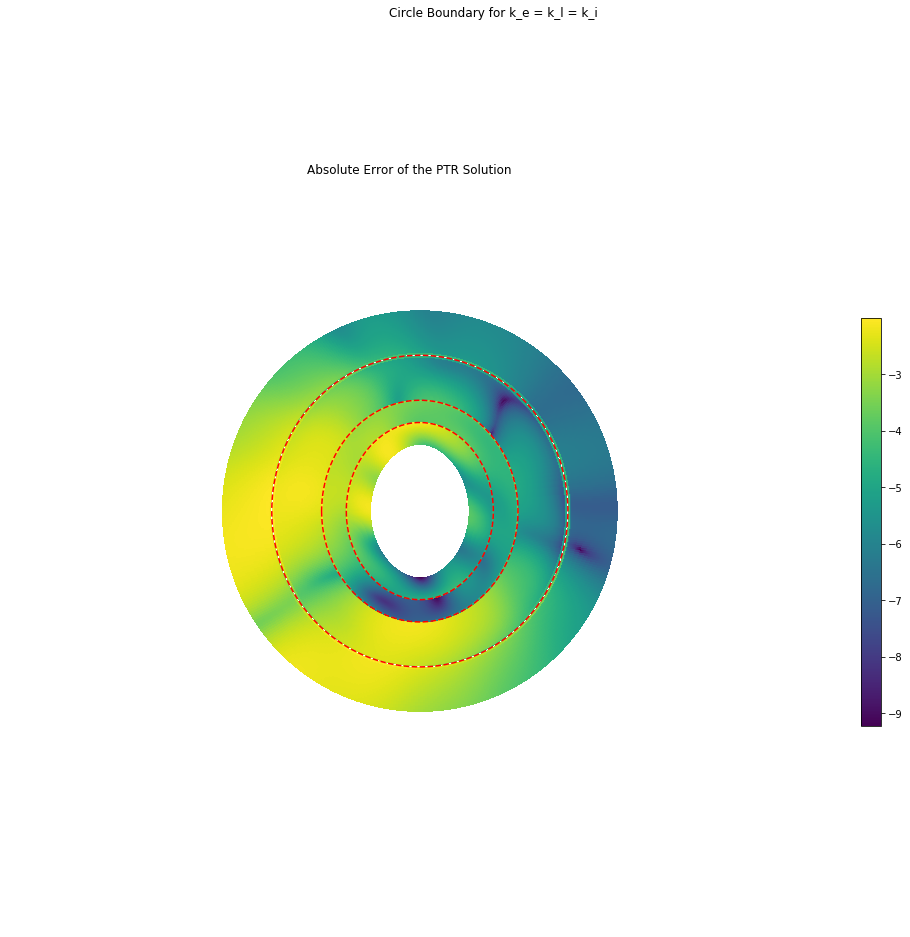

In [18]:
fig = plt.figure(figsize=(18,15))
fig.suptitle("Circle Boundary for k_e = k_l = k_i");
ax = fig.add_subplot(1 ,1 ,1, projection='3d', proj_type='ortho')
ax.view_init(90,90)
real1 = ax.plot_surface(x_e, y_e,  np.log(np.absolute((v_e-exact_e))), rstride=1, cstride=1, cmap=plt.get_cmap('viridis'), linewidth=0, antialiased=False)
real2 = ax.plot_surface(x_l, y_l, np.log(np.absolute((v_l-exact_l))), rstride=1, cstride=1, cmap=plt.get_cmap('viridis'), linewidth=0, antialiased=False)
for i in range(0,layers):
    ax.plot_surface(x_i[i], y_i[i], np.log(np.absolute((v_i[i]-exact_i[i]))), rstride=1, cstride=1, cmap=plt.get_cmap('viridis'), linewidth=0, antialiased=False)
    ax.plot(x_i[i][:,0], y_i[i][:,0], 'r--', zorder =(layers*3))
    
ax.plot(xbdy, ybdy, 'r--', zorder =5)
plt.title("Absolute Error of the PTR Solution")
fig.colorbar(real1, shrink=0.5);
plt.axis('off')
plt.grid(b=None)

<h2>References</h2>
<ol>
    <li>R. Kress, Boundary Integral Equations in Time-Harmonic Acoustic Scattering. Math Comput. Model (1991).</li>
    <li>C. Carvalho, S. Khatri, and A.D. Kim, Asymptotic analysis for close evaluation of layer potentials, submitted. J. Comp. Phys. (2018).</li>
</ol>

<h1>Current Issues</h1>
<ul> 
    <li>Error propogates over each interior layer, but this is expected since we use data near the boundary to solve the next layer.</li>
    <li>Method is not as nice for many layers / non-circular boundaries, also due to layers per error and error from curvature. </li>
</ul>